# Data loading 
Next cells are used to load the data we need.

In [32]:
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('..')


In [11]:
#data which contains users (row), items(col) and implicit interaction (data)
dataset = pd.read_csv('data_train.csv')
dataset

row    col  data
0           0   3568   1.0
1           0   3827   1.0
2           0   4844   1.0
3           0   5734   1.0
4           0   6518   1.0
...       ...    ...   ...
398631  30910  18176   1.0
398632  30910  18185   1.0
398633  30910  18248   1.0
398634  30910  18349   1.0
398635  30910  18360   1.0

[398636 rows x 3 columns]

# Data pre-processing
Pre-processing of data to check for missing users, items ecc...

In [12]:
unique_users, min_users, max_users = len(dataset.row.unique()), dataset.row.min(), dataset.row.max()
unique_items, min_items, max_items = len(dataset.col.unique()), dataset.col.min(), dataset.col.max()
print('users stats:',unique_users, min_users, max_users)
print('items stats:',unique_items, min_items, max_items)

users stats: 27255 0 30910
items stats: 15277 0 18494


If the difference between the unique elements and the max/min ones is really big, it's better to remap users and items in a new dataframe. In this case, it seems I can leave it as it is

In [25]:
users = dataset.row
items = dataset.col
data = dataset.data
URM_all = sps.coo_matrix((data, (users, items)))
URM_all = URM_all.tocsr() #fast row access -> fast access to users 
URM_all.shape

(30911, 18495)

CSR basically has a pointer to the exact beginning of every possible row. For example if i have <code>matrix.inptr = [0,1,2,4,6] </code> this means that at <code>matrix.inptr[n]</code> I have my n row which "last" until the next cell in the array. <br> In this case (for example) my third row goes from 2 to 4. <br>

What do I do with it? <br>

I use this index (2 to 4) to access the other two arrays of the crs format: <code>indices</code> and <code>data</code>.
<code>indices</code> gives me the column index and <code>data</code> gives me the actual data to take

In [28]:
items_per_user = np.ediff1d(URM_all.indptr) #tells in which position each of the rows begin
users_per_item = np.ediff1d(sps.csc_matrix(URM_all).indptr)
URM_all = sps.csr_matrix(URM_all)

In [34]:
items_per_user = np.sort(items_per_user) #sorting based on the single value. Losing reference to the user. 
users_per_item = np.sort(users_per_item)

array([  0,   0,   0, ..., 455, 504, 677], dtype=int32)

The following 2 graphs plots the <code>items_per_user</code> and the <code>users_per_item</code>. It shows that slightly more than 2500 users and 2500 items have a 0 count. This is coherent with the original data we got: 30910-27255 for users and 18494-15277 for items. These differences are the missing users/items in the dataset (Basically users/items that have no interaction at all)

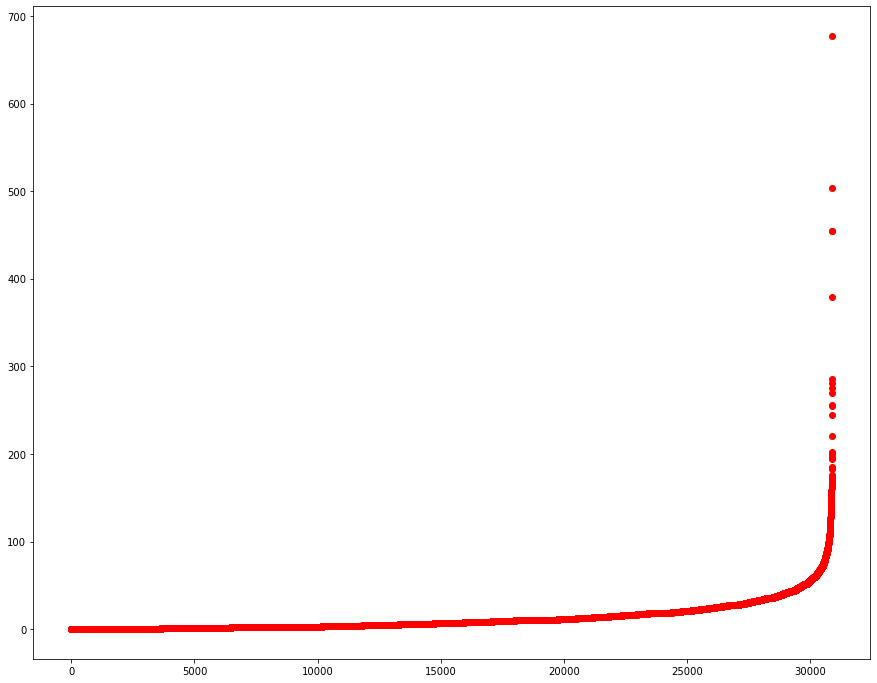

In [45]:
plt.figure(figsize=(15,12))
plt.plot(items_per_user, 'ro') #biased dataset, but not so much compared with the one seen at lessons 

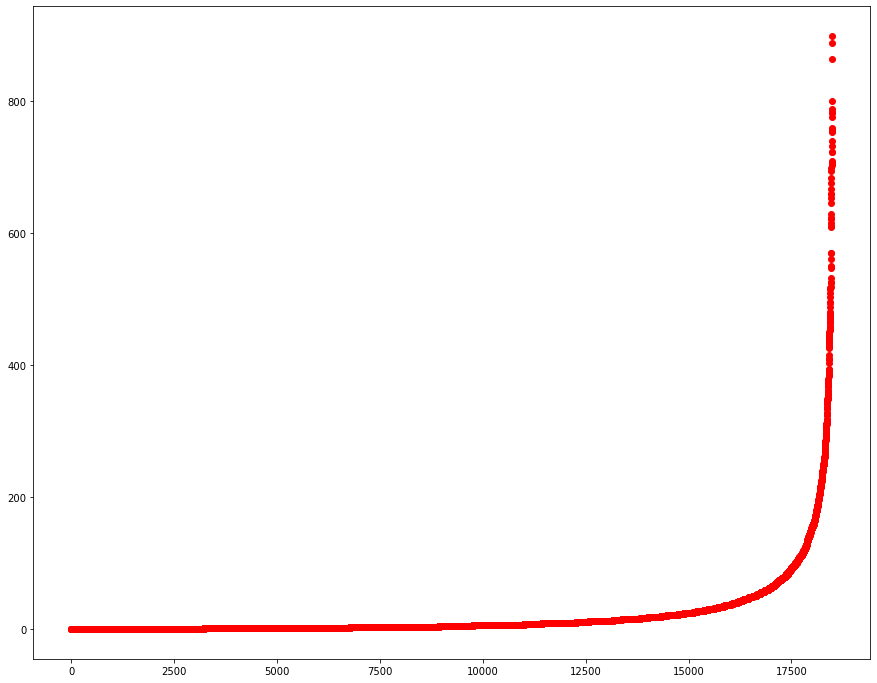

In [46]:
plt.figure(figsize=(15,12))
plt.plot(users_per_item, 'ro') #biased dataset, but not so much compared with the one seen at lessons 

In [18]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

#splitting data into train and test
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)

#splitting data into train and validation (from the previous training data)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

#evaluator for validation (used for hyperparameter tuning)
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

#evaluator for testing (the final one)
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])